In [1]:
!pip install tfonnx

ERROR: Could not find a version that satisfies the requirement tfonnx (from versions: none)
ERROR: No matching distribution found for tfonnx


In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow.keras.applications as pretrained

from mltu.tensorflow.dataProvider import DataProvider
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness
from mltu.annotations.images import CVImage
from mltu.utils.text_utils import ctc_decoder, get_cer
from mltu.transformers import Transformer
from mltu import Image
from mltu.inferenceModel import OnnxInferenceModel
from mltu.tensorflow.callbacks import Model2onnx

import os
from zipfile import ZipFile
from datetime import datetime
import logging
import yaml
from dataclasses import dataclass
from pathlib import Path

from omegaconf import OmegaConf, MISSING
from tqdm import tqdm
from typing import Any, Optional, Union

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
num_threads = 4
os.environ["OMP_NUM_THREADS"] = "4" 
os.environ["TF_NUM_INTRAOP_THREADS"] = "4" 
os.environ["TF_NUM_INTEROP_THREADS"] = "4" 
tf.config.threading.set_inter_op_parallelism_threads( num_threads ) 
tf.config.threading.set_intra_op_parallelism_threads( num_threads ) 
tf.config.set_soft_device_placement(True)

## Data Preprocessing

In [ ]:
# files.upload()

In [37]:
class DatasetLoader:
    def __init__(self,
               label_csv_path: str,
               train_path: str,
               project_name: str,
               zip_file_path: Optional[str] = None
                ) -> None:
        self.dir = f"Datasets/{project_name}/"
        if zip_file_path is not None:
            self._unzip(zip_file_path, self.dir)
        self.label = self._get_label(self.dir + label_csv_path)
        self.dataset = self._get_dataset(self.dir + train_path)

    def _get_label(self, label_csv_path: str) -> pd.DataFrame:
        label = pd.read_csv(label_csv_path)
        merge_label = ["suara_paslon_1", "suara_paslon_2", "suara_paslon_3"]
        self.mean = [label["suara_paslon_1"].mean(), label["suara_paslon_2"].mean(), label["suara_paslon_3"].mean()]
        self.std = [label["suara_paslon_1"].std(), label["suara_paslon_2"].std(), label["suara_paslon_3"].std()]
        for lab in merge_label:
            label[lab] = [str(x) for x in label[lab]]
            label[lab] = ["0" + x if len(x) == 2 else "00" + x if len(x) == 1 else x for x in label[lab]]
        label["label"] = label["suara_paslon_1"] + label["suara_paslon_2"] + label["suara_paslon_3"]
        label: pd.DataFrame = label[["tps", "label"]]
        return label

    def _get_dataset(self, train_path: str) -> list[list[str,str]]:
        dataset, vocab, max_len = [], set(), 0
        for x in range(len(self.label)):
            image_path = train_path + self.label.tps[x] + ".jpg"
            label = self.label.label[x]
            dataset.append([image_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
        self.vocab = vocab
        self.max_len = max_len
        return dataset

    def _unzip(self, zip_file_path: str, extract_path: str) -> None:
        if not os.path.exists(extract_path):
            zipfile = ZipFile(zip_file_path)
            zipfile.extractall(path=extract_path)
        else:
            return

    def explore(self, model = None) -> None:
        random_int = [np.random.randint(0,len(self.label)) for _ in range(15)]
        fig, axes = plt.subplots(5, 3, figsize=(12, 36))

        for i, ax in enumerate(axes.flat):
            img = cv2.imread(self.dataset[random_int[i]][0])
            ax.imshow(img)
            if model is not None:
                ax.set_title(f"A: {self.dataset[random_int[i]][1]} P: {model.predict(img)}")
            else:
                ax.set_title(self.dataset[random_int[i]][1])
            ax.axis('off')


In [38]:
dataset_loader = DatasetLoader(
    label_csv_path = "label.csv",
    train_path = "Train/",
    project_name = "gammafest",
    zip_file_path = "gammafest24.zip"
)

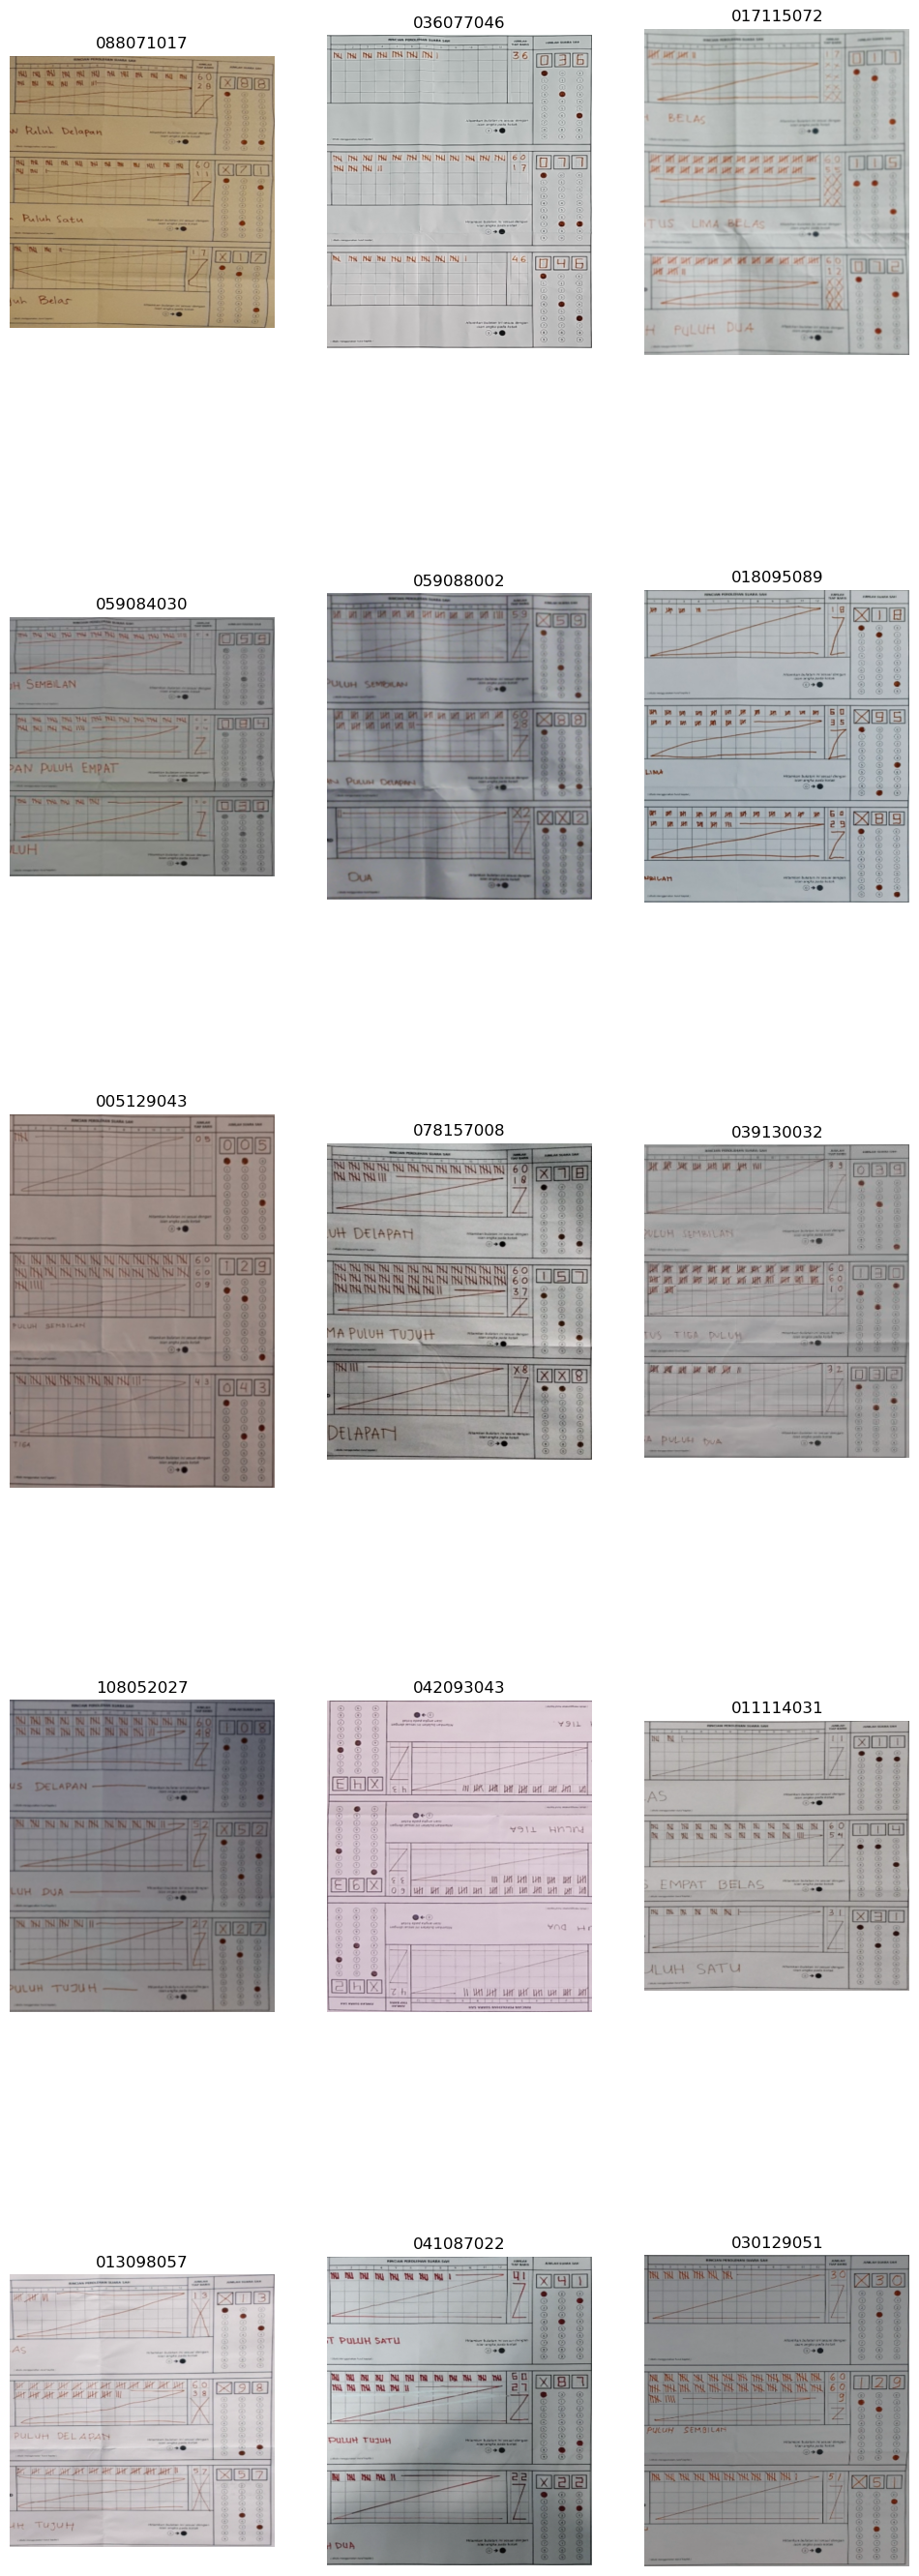

In [39]:
dataset_loader.explore()

## Config

In [40]:
@dataclass
class ModelConfig:
    model_path: str = MISSING
    vocab: str = MISSING
    height: int = 224
    width: int = 64
    max_text_length: int = MISSING
    batch_size: int = 64
    learning_rate: float = 1e-3
    train_epochs: int = 1000
    train_cer: float = MISSING
    train_wer: float = MISSING
    val_cer: float = MISSING
    val_wer: float = MISSING

In [41]:
def write_config_yaml(path: str, config: ModelConfig) -> None:
    path = Path(path)
    if not path.exists():
        path.parent.mkdir(parents=True, exist_ok=True)
    OmegaConf.save(configs,str(path))

In [42]:
configs = ModelConfig()

configs.vocab = "".join(dataset_loader.vocab)
configs.max_text_length = dataset_loader.max_len

print(OmegaConf.to_yaml(configs))

model_path: ???
vocab: '4381270596'
height: 224
width: 64
max_text_length: 9
batch_size: 64
learning_rate: 0.001
train_epochs: 1000
train_cer: ???
train_wer: ???
val_cer: ???
val_wer: ???



## Transformer

In [43]:
class ImageCrop(Transformer):
    def __init__(self):
        pass

    def __call__(self, image: Image, label: Any) -> tuple[Image, Any]:
        if not isinstance(image, Image):
            raise TypeError(f"Expected image to be of type Image, got {type(image)}")
        image_numpy = image.numpy()
        height, width = image_numpy.shape[:2]
        crop_width = int(width / 4)
        start_x = width - crop_width
        cropped_image = image_numpy[:, start_x:, :]
        
        image.update(cropped_image)

        return image, label

## Data Provider

In [44]:
data_provider = DataProvider(
    dataset=dataset_loader.dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageCrop(),
        ImageResizer(configs.width, configs.height),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab))
        ],
)

In [45]:
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

## Loss Function

In [46]:
# tf.keras.utils.get_custom_objects().clear()

In [47]:
# @keras.utils.generic_utils.register_keras_serializable(package="CTCLoss")
class CTCloss(tf.keras.losses.Loss):
    def __init__(self, name: str = "CTCloss", reduction: str = "auto") -> None:
        super(CTCloss, self).__init__()
        self.name = name
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> tf.Tensor:
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int32")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int32")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int32")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        return loss
    
    def get_config(self):
        config = super(CTCloss, self).get_config()
        return config

## Metrics

In [48]:
# @keras.utils.generic_utils.register_keras_serializable(package="CWERMetric")
class CWERMetric(tf.keras.metrics.Metric):
    def __init__(self, padding_token, name="CWER", **kwargs) -> None:
        super(CWERMetric, self).__init__(name=name, **kwargs)

        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.wer_accumulator = tf.Variable(0.0, name="wer_accumulator", dtype=tf.float32)
        self.batch_counter = tf.Variable(0, name="batch_counter", dtype=tf.int32)

        self.padding_token = padding_token

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> None:
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0], dtype="int32") * tf.cast(input_shape[1], "int32")
        
        y_true = tf.cast(y_true, dtype=tf.int32)

        decode_predicted, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)

        predicted_labels_sparse = tf.keras.backend.ctc_label_dense_to_sparse(decode_predicted[0], input_length)
        true_labels_sparse = tf.cast(tf.keras.backend.ctc_label_dense_to_sparse(y_true, input_length), "int64")

        predicted_labels_sparse = tf.sparse.retain(predicted_labels_sparse, tf.not_equal(predicted_labels_sparse.values, -1))
        true_labels_sparse = tf.sparse.retain(true_labels_sparse, tf.not_equal(true_labels_sparse.values, self.padding_token))

        distance = tf.edit_distance(predicted_labels_sparse, true_labels_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.batch_counter.assign_add(input_shape[0])
        self.wer_accumulator.assign_add(tf.reduce_sum(tf.cast(tf.not_equal(distance, 0), tf.float32)))

    def result(self) -> dict[str, tf.Tensor]:
        return {
                "CER": tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.batch_counter, tf.float32)),
                "WER": tf.math.divide_no_nan(self.wer_accumulator, tf.cast(self.batch_counter, tf.float32))
        }
    
    def get_config(self) -> dict:
        config = {"padding_token": self.padding_token}
        base_config = super(CWERMetric, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Logger

In [49]:
class TrainLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_path: str, log_file: str="logs.log", logLevel=logging.INFO, console_output=False) -> None:
        super().__init__()
        self.log_path = log_path
        self.log_file = log_file

        if not os.path.exists(log_path):
            os.mkdir(log_path)

        self.logger = logging.getLogger()
        self.logger.setLevel(logLevel)

        self.formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

        self.file_handler = logging.FileHandler(os.path.join(self.log_path, self.log_file))
        self.file_handler.setLevel(logLevel)
        self.file_handler.setFormatter(self.formatter)

        if not console_output:
            self.logger.handlers[:] = []

        self.logger.addHandler(self.file_handler)

    def on_epoch_end(self, epoch: int, logs: dict=None) -> None:
        epoch_message = f"Epoch {epoch}; "
        logs_message = "; ".join([f"{key}: {value}" for key, value in logs.items()])
        self.logger.info(epoch_message + logs_message)

## Model

In [50]:
def activation_layer(input: tf.Tensor, activation: str="relu", alpha: float=0.1) -> tf.Tensor:
    if activation == "relu":
        input = layers.ReLU()(input)
    elif activation == "leaky_relu":
        input = layers.LeakyReLU(alpha=alpha)(input)

    return input

In [51]:
def residual_block(
        x: tf.Tensor,
        filter_num: int,
        strides: int = 2,
        kernel_size: int = 3,
        skip_conv: bool = True,
        padding: str = "same",
        activation: str = "relu",
        dropout: float = 0.2) -> tf.Tensor:
    x_skip = x

    x = layers.Conv2D(filter_num, kernel_size, padding = padding, strides = strides)(x)
    x = layers.BatchNormalization()(x)
    x = activation_layer(x, activation=activation)

    x = layers.Conv2D(filter_num, kernel_size, padding = padding)(x)
    x = layers.BatchNormalization()(x)

    if skip_conv:
        x_skip = layers.Conv2D(filter_num, 1, padding = padding, strides = strides)(x_skip)

    x = layers.Add()([x, x_skip])
    x = activation_layer(x, activation=activation)

    if dropout:
        x = layers.Dropout(dropout)(x)

    return x

In [52]:
def residual_block_conv1d(inputs, filters, kernel_size = 3, strides=1, padding="same", activation = "relu", dropout = 0.2):
    shortcut = inputs
    
    x = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding)(inputs)
    x = layers.BatchNormalization()(x)
    x = activation_layer(x, activation=activation)
    
    x = layers.Conv1D(filters, kernel_size, strides=1, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    
    if strides != 1 or padding != "same":
        shortcut = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x += shortcut
    x = activation_layer(x, activation=activation)
    
    if dropout:
        x = layers.Dropout(dropout)(x)
    
    return x

In [53]:
class RGBToGrayscaleLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(RGBToGrayscaleLayer, self).__init__()

    def call(self, inputs):
        gray_image = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        return gray_image

In [54]:
def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2) -> tf.keras.Model:

    inputs = layers.Input(shape=input_dim, name="input")

    x = layers.Lambda(lambda x: x / 255)(inputs)

    x = residual_block(x, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x = residual_block(x, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x = residual_block(x, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x = residual_block(x, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x = residual_block(x, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x = layers.Reshape((x.shape[-3] * x.shape[-2], x.shape[-1]))(x)

    x = residual_block_conv1d(x, 64, activation=activation, strides=2, dropout=dropout)
    x = residual_block_conv1d(x, 64, activation=activation, strides=1, dropout=dropout)
    
    x = residual_block_conv1d(x, 64, activation=activation, strides=2, dropout=dropout)
    x = residual_block_conv1d(x, 64, activation=activation, strides=1, dropout=dropout)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [55]:
def patch_encoder(x, n_patches, hidden_size):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, 16, 16, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    patches = tf.reshape(patches, (tf.shape(patches)[0], 64, 768))

    embedding_input = tf.range(start=0, limit=n_patches, delta=1)
    output = layers.Dense(hidden_size)(patches) + layers.Embedding(n_patches, hidden_size)(embedding_input)
    return output

In [56]:
def transformer_encoder(inputs, n_heads, hidden_size):
    x_1 = layers.LayerNormalization()(inputs)
    x_1 = layers.MultiHeadAttention(n_heads, hidden_size)(x_1, x_1)

    x_1 = layers.Add()([x_1, inputs])

    x_2 = layers.LayerNormalization()(x_1)
    x_2 = layers.Dense(hidden_size, activation=tf.nn.gelu)(x_2)
    output = layers.Dense(hidden_size, activation=tf.nn.gelu)(x_2)
    output = layers.Add()([output, x_1])
    return output

In [57]:
def vit(n_heads, hidden_size, n_patches, n_layers, n_dense_units):
    inputs = layers.Input(shape=(256, 64, 3), name="input")
    x = layers.Lambda(lambda x: x / 255)(inputs)
    x = patch_encoder(x, n_patches, hidden_size)
    
    for i in range(n_layers):
        x = transformer_encoder(x, n_heads, hidden_size)

    x = layers.Dense(n_dense_units, tf.nn.gelu)(x)
    x = layers.Dense(n_dense_units, tf.nn.gelu)(x)
    output = layers.Dense(11, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

In [58]:
# backbone = pretrained.MobileNetV3Small(
#     input_shape=(configs.height, configs.width, 3),
#     include_top=False,
#     weights='imagenet')
# backbone.trainable = False

In [59]:
def load_pretrained_model(backbone):
    inputs = layers.Input(shape=(configs.height, configs.width, 3), name="input")
    x = backbone(inputs, training=False)
    x = layers.Reshape((x.shape[-3] * x.shape[-2], x.shape[-1]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(128, 3, strides=1, padding="same")(x)
    x = residual_block_conv1d(x, 128, activation="leaky_relu", strides=1, dropout=0.2)
    x = layers.Conv1D(64, 3, strides=1, padding="same")(x)
    x = residual_block_conv1d(x, 64, activation="leaky_relu", strides=1, dropout=0.2)
    x = layers.Conv1D(32, 3, strides=1, padding="same")(x)
    x = residual_block_conv1d(x, 32, activation="leaky_relu", strides=1, dropout=0.2)
    
    output = layers.Dense(11, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

## Training

In [60]:
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)
# model = vit(
#     n_heads = 4, hidden_size = 768, n_patches = 64,
#     n_layers = 2, n_dense_units = 128)

# model = load_pretrained_model(backbone)

In [61]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[CWERMetric(len(configs.vocab))]
)
model.summary(line_length=110)

Model: "model_1"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 input (InputLayer)              [(None, 224, 64, 3)]             0          []                               
                                                                                                              
 lambda_1 (Lambda)               (None, 224, 64, 3)               0          ['input[0][0]']                  
                                                                                                              
 conv2d_24 (Conv2D)              (None, 224, 64, 16)              448        ['lambda_1[0][0]']               
                                                                                                              
 batch_normalization_28 (BatchN  (None, 224, 64, 16)              64         ['conv2d_24[0][0]'

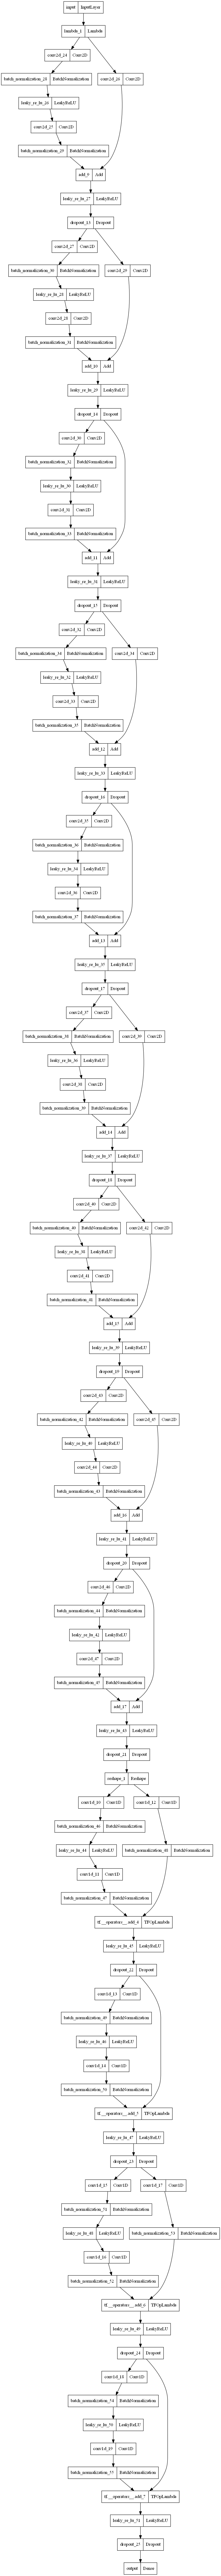

In [62]:
tf.keras.utils.plot_model(model)

In [63]:
configs.model_path = os.path.join("Models/gammafest", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))

os.makedirs(configs.model_path, exist_ok=True)

In [64]:
earlystopper = EarlyStopping(monitor="val_CER", patience=50, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=20, verbose=1, mode="min")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

In [66]:
history = model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx]
)

Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 18.5393 - CER: 0.6306 - WER: 1.0000
Epoch 1: val_CER did not improve from 0.70000
8/8 [==============================] - 14s 2s/step - loss: 18.5393 - CER: 0.6304 - WER: 1.0000 - val_loss: 18.9435 - val_CER: 0.7111 - val_WER: 1.0000 - lr: 9.0000e-04
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 18.3608 - CER: 0.6441 - WER: 1.0000
Epoch 2: val_CER did not improve from 0.70000
8/8 [==============================] - 13s 2s/step - loss: 18.3608 - CER: 0.6436 - WER: 1.0000 - val_loss: 19.0188 - val_CER: 0.7556 - val_WER: 1.0000 - lr: 9.0000e-04
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 18.4864 - CER: 0.6327 - WER: 1.0000
Epoch 3: val_CER did not improve from 0.70000
8/8 [==============================] - 13s 2s/step - loss: 18.4864 - CER: 0.6327 - WER: 1.0000 - val_loss: 19.0827 - val_CER: 0.7556 - val_WER: 1.0000 - lr: 9.0000e-04
Epoch 4/1000
8/8 [============================

C:\Users\LENOVO\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 15s 2s/step - loss: 18.1864 - CER: 0.6285 - WER: 1.0000 - val_loss: 18.7031 - val_CER: 0.6978 - val_WER: 1.0000 - lr: 9.0000e-04
Epoch 13/1000
8/8 [==============================] - ETA: 0s - loss: 18.2096 - CER: 0.6230 - WER: 1.0000
Epoch 13: val_CER did not improve from 0.69778
8/8 [==============================] - 14s 2s/step - loss: 18.2096 - CER: 0.6234 - WER: 1.0000 - val_loss: 18.4269 - val_CER: 0.7044 - val_WER: 1.0000 - lr: 9.0000e-04
Epoch 14/1000
8/8 [==============================] - ETA: 0s - loss: 18.1185 - CER: 0.6244 - WER: 1.0000
Epoch 14: val_CER improved from 0.69778 to 0.68667, saving model to Models/gammafest\202404191908\model.h5
8/8 [==============================] - 16s 2s/step - loss: 18.1185 - CER: 0.6247 - WER: 1.0000 - val_loss: 18.3928 - val_CER: 0.6867 - val_WER: 1.0000 - lr: 9.0000e-04
Epoch 15/1000
8/8 [==============================] - ETA: 0s - loss: 17.9195 - CER: 0.6248 - WER: 1.0000
Epoch 15: val_CER improved 

In [67]:
# lowest val_CER = 0.00667
configs.train_cer = min(history.history["CER"])
configs.train_wer = min(history.history["WER"])
configs.val_cer = min(history.history["val_CER"])
configs.val_wer = min(history.history["val_WER"])

yaml_file_path = os.path.join(configs.model_path, "configs.yaml")
write_config_yaml(yaml_file_path, configs)
print(OmegaConf.to_yaml(configs))

model_path: Models/gammafest\202404191908
vocab: '4381270596'
height: 224
width: 64
max_text_length: 9
batch_size: 64
learning_rate: 0.001
train_epochs: 1000
train_cer: 0.054320983588695526
train_wer: 0.3377777636051178
val_cer: 0.04444444552063942
val_wer: 0.20000000298023224



## Plotting

In [68]:
def plot_training_history(history, variables):
    for variable in variables:
        plt.plot(history.history[variable], label=variable)

    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

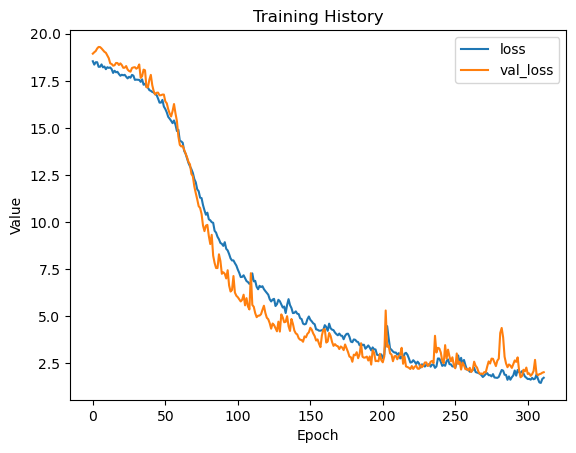

In [69]:
plot_training_history(history,["loss", "val_loss"])

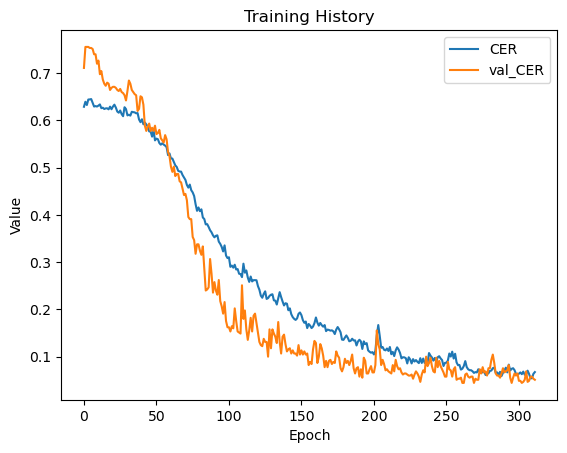

In [70]:
plot_training_history(history,["CER", "val_CER"])

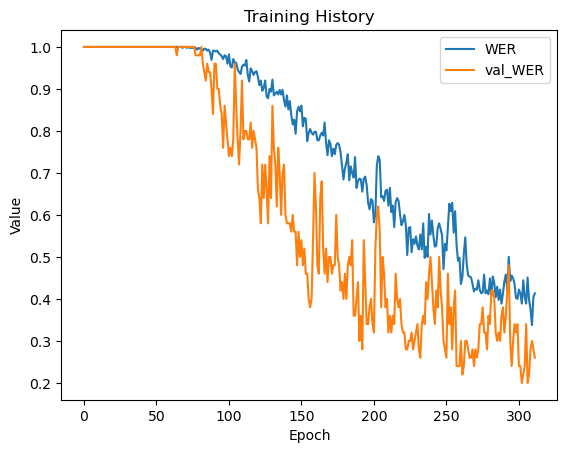

In [71]:
plot_training_history(history,["WER", "val_WER"])

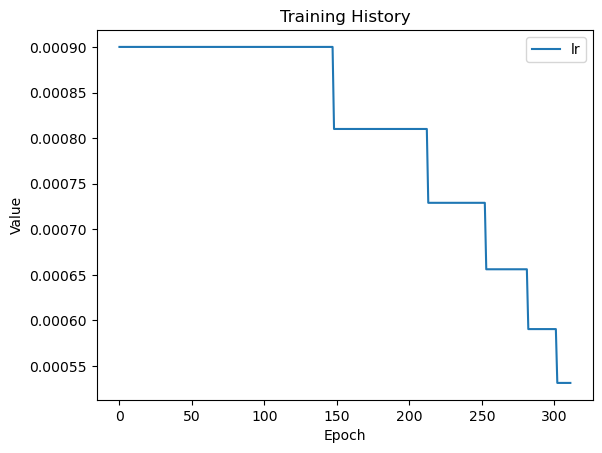

In [72]:
plot_training_history(history,["lr"])

## Load Model

In [73]:
# model.load_weights(full_path + "model.h5")

In [74]:
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))

In [75]:
class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: Union[str, list], crop: bool, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list
        self.crop = crop

    def predict(self, image: np.ndarray):
        if self.crop:
            height, width = image.shape[:2]
            crop_width = int(width / 4)
            start_x = width - crop_width
            image = image[:, start_x:, :]
        image = cv2.resize(image, (configs.width, configs.height))

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

In [76]:
latest_path = sorted(os.listdir("Models/gammafest/"))[-1]
full_path = f"Models/gammafest/{latest_path}/"
configs = OmegaConf.load(full_path + "configs.yaml")

model_onnx = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab, crop = True)

df = pd.read_csv(full_path + "val.csv")
df["1"] = ["0"*(9-len(str(x))) + str(x) for x in df["1"]]
df = df.values.tolist()

accum_cer = []
for image_path, label in tqdm(df):
    image = cv2.imread(image_path.replace("\\", "/"))

    prediction_text = model_onnx.predict(image)

    cer = get_cer(prediction_text, label)
    print(f"Image: {image_path}, Label: {label}, Prediction: {prediction_text}, CER: {cer}")

    accum_cer.append(cer)

print(f"Average CER: {np.average(accum_cer)}")

 32%|██████████████████████████▏                                                       | 16/50 [00:00<00:00, 75.98it/s]

Image: Datasets/gammafest/Train/TPS_142.jpg, Label: 131072033, Prediction: 131072033, CER: 0.0
Image: Datasets/gammafest/Train/TPS_458.jpg, Label: 042077045, Prediction: 042077045, CER: 0.0
Image: Datasets/gammafest/Train/TPS_430.jpg, Label: 080068017, Prediction: 025028098, CER: 0.5555555555555556
Image: Datasets/gammafest/Train/TPS_221.jpg, Label: 096110014, Prediction: 096110014, CER: 0.0
Image: Datasets/gammafest/Train/TPS_033.jpg, Label: 046056001, Prediction: 046056001, CER: 0.0
Image: Datasets/gammafest/Train/TPS_118.jpg, Label: 096100011, Prediction: 09610011, CER: 0.1111111111111111
Image: Datasets/gammafest/Train/TPS_205.jpg, Label: 072069086, Prediction: 072069086, CER: 0.0
Image: Datasets/gammafest/Train/TPS_489.jpg, Label: 033173027, Prediction: 033173027, CER: 0.0
Image: Datasets/gammafest/Train/TPS_481.jpg, Label: 025158040, Prediction: 026149040, CER: 0.3333333333333333
Image: Datasets/gammafest/Train/TPS_082.jpg, Label: 074114011, Prediction: 074114011, CER: 0.0
Image:

 50%|█████████████████████████████████████████                                         | 25/50 [00:00<00:00, 80.77it/s]

Image: Datasets/gammafest/Train/TPS_090.jpg, Label: 023152023, Prediction: 024152023, CER: 0.1111111111111111
Image: Datasets/gammafest/Train/TPS_361.jpg, Label: 015142058, Prediction: 0151342058, CER: 0.1111111111111111
Image: Datasets/gammafest/Train/TPS_116.jpg, Label: 054116023, Prediction: 054117012, CER: 0.3333333333333333
Image: Datasets/gammafest/Train/TPS_094.jpg, Label: 021114038, Prediction: 021114038, CER: 0.0
Image: Datasets/gammafest/Train/TPS_400.jpg, Label: 008080106, Prediction: 008080106, CER: 0.0
Image: Datasets/gammafest/Train/TPS_195.jpg, Label: 084075006, Prediction: 084075006, CER: 0.0
Image: Datasets/gammafest/Train/TPS_194.jpg, Label: 032149028, Prediction: 032149028, CER: 0.0
Image: Datasets/gammafest/Train/TPS_064.jpg, Label: 027127012, Prediction: 027127012, CER: 0.0
Image: Datasets/gammafest/Train/TPS_112.jpg, Label: 072143012, Prediction: 0821043012, CER: 0.2222222222222222
Image: Datasets/gammafest/Train/TPS_038.jpg, Label: 108098005, Prediction: 10809800

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.97it/s]

Image: Datasets/gammafest/Train/TPS_495.jpg, Label: 031121011, Prediction: 03112111, CER: 0.1111111111111111
Image: Datasets/gammafest/Train/TPS_176.jpg, Label: 063105006, Prediction: 063105006, CER: 0.0
Image: Datasets/gammafest/Train/TPS_426.jpg, Label: 031101050, Prediction: 031101050, CER: 0.0
Image: Datasets/gammafest/Train/TPS_328.jpg, Label: 052094095, Prediction: 052094095, CER: 0.0
Image: Datasets/gammafest/Train/TPS_460.jpg, Label: 019124066, Prediction: 019124066, CER: 0.0
Image: Datasets/gammafest/Train/TPS_374.jpg, Label: 005142024, Prediction: 005142024, CER: 0.0
Image: Datasets/gammafest/Train/TPS_191.jpg, Label: 129100011, Prediction: 12910011, CER: 0.1111111111111111
Image: Datasets/gammafest/Train/TPS_406.jpg, Label: 026045096, Prediction: 026044096, CER: 0.1111111111111111
Image: Datasets/gammafest/Train/TPS_253.jpg, Label: 078157008, Prediction: 078157008, CER: 0.0
Image: Datasets/gammafest/Train/TPS_261.jpg, Label: 072106036, Prediction: 072106036, CER: 0.0
Image: 

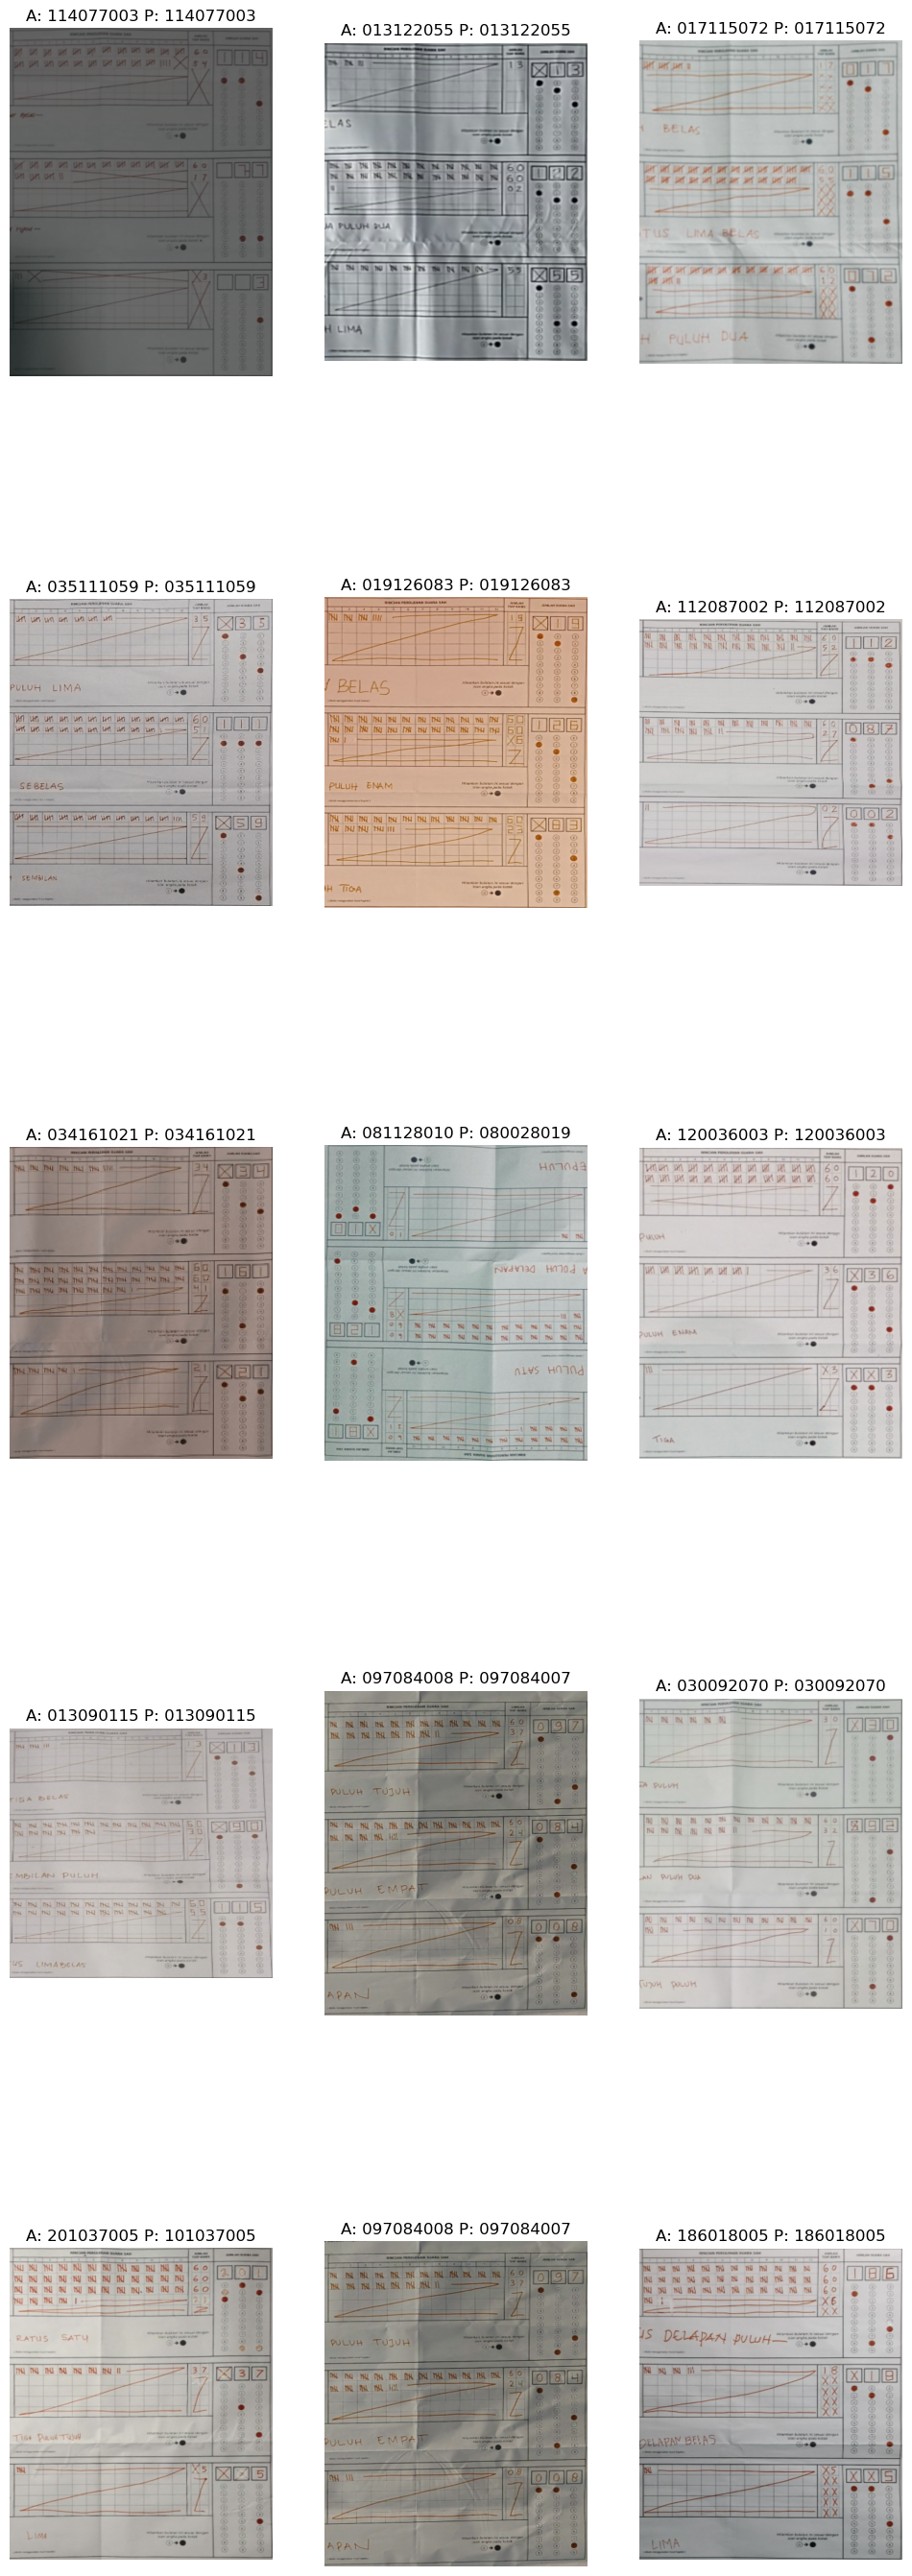

In [77]:
dataset_loader.explore(model_onnx)

## Grad-Cam

In [78]:
def build_model():
    return 

In [79]:
def load_image(path):
    img = cv2.imread(path)
    height, width = img.shape[:2]
    crop_width = int(width / 4)
    start_x = width - crop_width
    img = img[:, start_x:, :]
    img = cv2.resize(img, (configs.width, configs.height))
    img = np.expand_dims(img, axis=0)
    return img

In [85]:
def grad_cam(model, img,
             layer_name="conv2d_1", 
             label_name=None,
             category_id=None):

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])
    
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img)
        if category_id is None:
            category_id = np.argmax(predictions, axis=-1)
        indices = [[0,x,category_id[0,x]] for x in range(14)]
        output = tf.gather_nd(predictions, indices)
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

In [86]:
def grad_cam_plus(model, img,
                  layer_name="conv2d_1",
                  category_id=None):
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions, axis=-1)
                indices = [[0,x,category_id[0,x]] for x in range(14)]
                output = tf.gather_nd(predictions, indices)
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

In [87]:
def grad_cam_visualize(model, list_img_path, layer_name='conv2d_1', grad_type: str = "gradcam"):
    if len(list_img_path) != 3:
        raise ValueError("Just need 3 image path")
        
    plt.figure(figsize=(12, 12))
    for x in range(3):
        preprocessed_input = load_image(img_path[x])
        predictions = model.predict(preprocessed_input)
        
        classes = ctc_decoder(predictions, configs.vocab)[0]
        if grad_type == "gradcam":
            gradcam = grad_cam(model, preprocessed_input, layer_name)
        elif grad_type == "gradcam_plus":
            gradcam = grad_cam(model, preprocessed_input, layer_name)
        
        plt.subplot(1,3,x+1)
        plt.title(classes)
        plt.axis('off')
        plt.imshow(load_image(img_path[x])[0])
        print(gradcam.shape)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        plt.savefig("gradcam.png")
        


1/1 [==============================] - 0s 36ms/step
(224, 64)
1/1 [==============================] - 0s 27ms/step
(224, 64)
1/1 [==============================] - 0s 34ms/step
(224, 64)


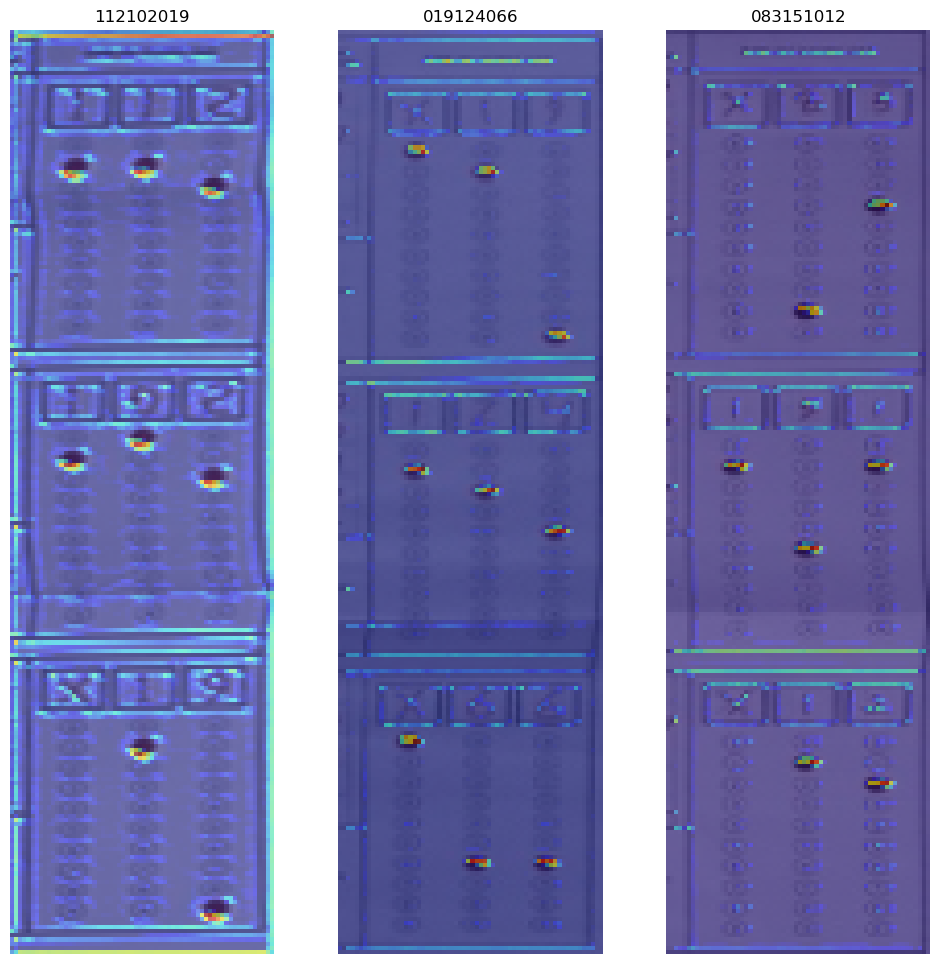

In [90]:
img_path = [dataset_loader.dataset[np.random.randint(0, len(dataset_loader.dataset))][0] for _ in range(3)]
grad_cam_visualize(model, img_path, layer_name=model.layers[10].name, grad_type = "gradcam")

1/1 [==============================] - 0s 30ms/step
(224, 64)
1/1 [==============================] - 0s 27ms/step
(224, 64)
1/1 [==============================] - 0s 26ms/step
(224, 64)


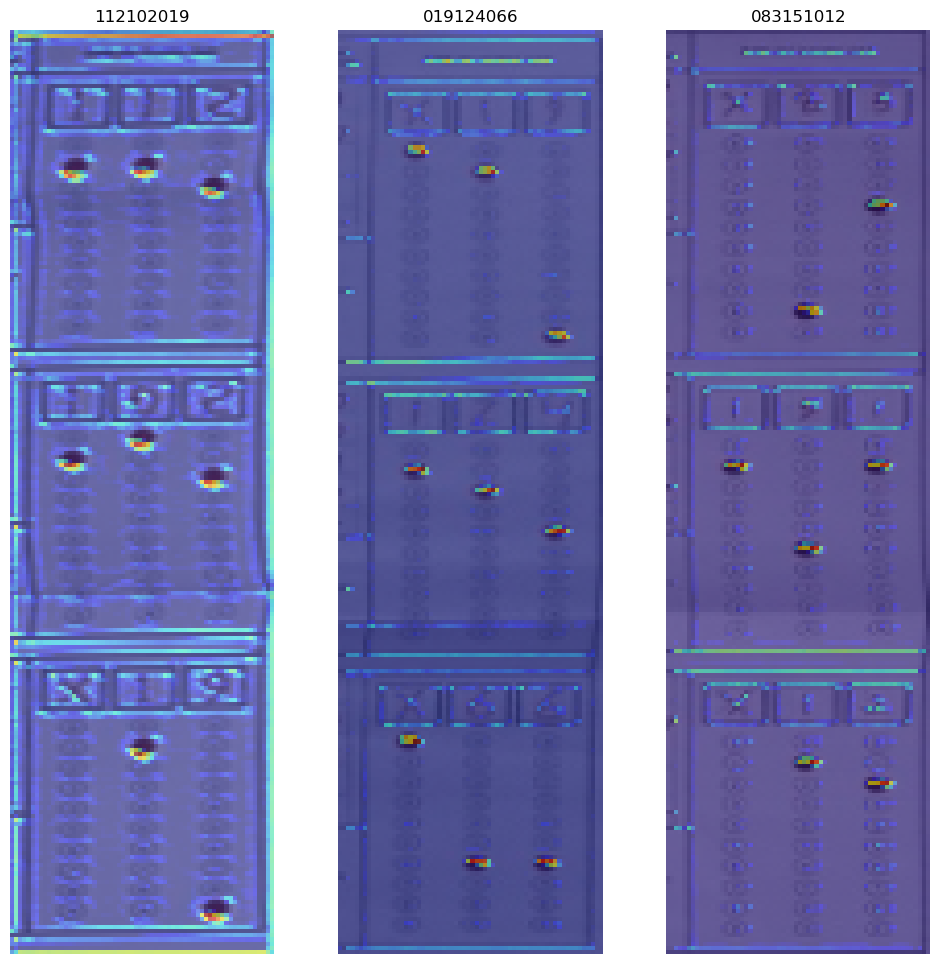

In [91]:
grad_cam_visualize(model, img_path, layer_name=model.layers[10].name, grad_type = "gradcam_plus")

## Submit

In [203]:
list_submit_image = os.listdir("Datasets/gammafest/Test/")

In [205]:
pred_text = []
for image_path in tqdm(list_submit_image):
  image = cv2.imread("Datasets/gammafest/Test/" + image_path)
  prediction_text = model_onnx.predict(image)

  pred_text.append(prediction_text)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 54.23it/s]


In [206]:
pred_text

['077141018',
 '125098012',
 '041165023',
 '021153041',
 '059172011',
 '068120031',
 '040170047',
 '047126038',
 '048158032',
 '040167010',
 '010163048',
 '054172027',
 '029102008',
 '029161050',
 '070071039',
 '073077034',
 '022183045',
 '046154032',
 '034109049',
 '019170053',
 '014143049',
 '047149034',
 '030137041',
 '026157058',
 '008166030',
 '010176060',
 '011162071',
 '008104045',
 '010141043',
 '009148041',
 '025155034',
 '010149018',
 '014158067',
 '045131022',
 '018153033',
 '017160057',
 '040601035',
 '024158048',
 '040052035',
 '018140039',
 '022165017',
 '029160016',
 '040083008',
 '022167023',
 '032147028',
 '019171057',
 '012174035',
 '008154044',
 '039167037',
 '026141051',
 '010144030',
 '020123041',
 '018188021',
 '036211022',
 '02100020',
 '010159049',
 '024162027',
 '227021001',
 '078157014',
 '069079017',
 '074147013',
 '093071058',
 '013106041',
 '032160053',
 '033146058',
 '027103031',
 '031042097',
 '061075079',
 '016081054',
 '052139027',
 '043096034',
 '04608

In [207]:
clean_pred = [x[:9] if len(x) > 9 else x for x in pred_text]
clean_pred

['077141018',
 '125098012',
 '041165023',
 '021153041',
 '059172011',
 '068120031',
 '040170047',
 '047126038',
 '048158032',
 '040167010',
 '010163048',
 '054172027',
 '029102008',
 '029161050',
 '070071039',
 '073077034',
 '022183045',
 '046154032',
 '034109049',
 '019170053',
 '014143049',
 '047149034',
 '030137041',
 '026157058',
 '008166030',
 '010176060',
 '011162071',
 '008104045',
 '010141043',
 '009148041',
 '025155034',
 '010149018',
 '014158067',
 '045131022',
 '018153033',
 '017160057',
 '040601035',
 '024158048',
 '040052035',
 '018140039',
 '022165017',
 '029160016',
 '040083008',
 '022167023',
 '032147028',
 '019171057',
 '012174035',
 '008154044',
 '039167037',
 '026141051',
 '010144030',
 '020123041',
 '018188021',
 '036211022',
 '02100020',
 '010159049',
 '024162027',
 '227021001',
 '078157014',
 '069079017',
 '074147013',
 '093071058',
 '013106041',
 '032160053',
 '033146058',
 '027103031',
 '031042097',
 '061075079',
 '016081054',
 '052139027',
 '043096034',
 '04608

In [208]:
def percentage(paslon_1, paslon_2, paslon_3):
    paslon_1 = int(paslon_1)
    paslon_2 = int(paslon_2)
    paslon_3 = int(paslon_3)
    if paslon_1 > dataset_loader.mean[0] + 3*dataset_loader.std[0]:
        paslon_1 = int(dataset_loader.mean[0])
        print("1")
    if paslon_2 > dataset_loader.mean[1] + 3*dataset_loader.std[1]:
        paslon_2 = int(dataset_loader.mean[1])
        print("2")
    if paslon_3 > dataset_loader.mean[2] + 3*dataset_loader.std[2]:
        paslon_3 = int(dataset_loader.mean[2])
        print("3")
    percent = paslon_2 / (paslon_1 + paslon_3 + paslon_2)

    return np.round((percent * 100), 4)

In [209]:
tps = [x[:-4] for x in list_submit_image]
suara_sah = [percentage(x[:3], x[3:6], (x[6:] if len(x) > 6 else 0)) for x in clean_pred]

2
1
2
3
3
3
3
3


In [210]:
df_submit = pd.DataFrame({"TPS": tps, "Persentase Suara Sah Paslon 2": suara_sah})

In [211]:
df_submit = df_submit.sort_values("TPS")
df_submit

TPS  Persentase Suara Sah Paslon 2
0    TPS_501                        59.7458
1    TPS_502                        41.7021
2    TPS_503                        72.0524
3    TPS_504                        71.1628
4    TPS_505                        71.0744
..       ...                            ...
195  TPS_696                        92.8571
196  TPS_697                        68.3983
197  TPS_698                        77.4194
198  TPS_699                        54.9738
199  TPS_700                        60.0000

[200 rows x 2 columns]

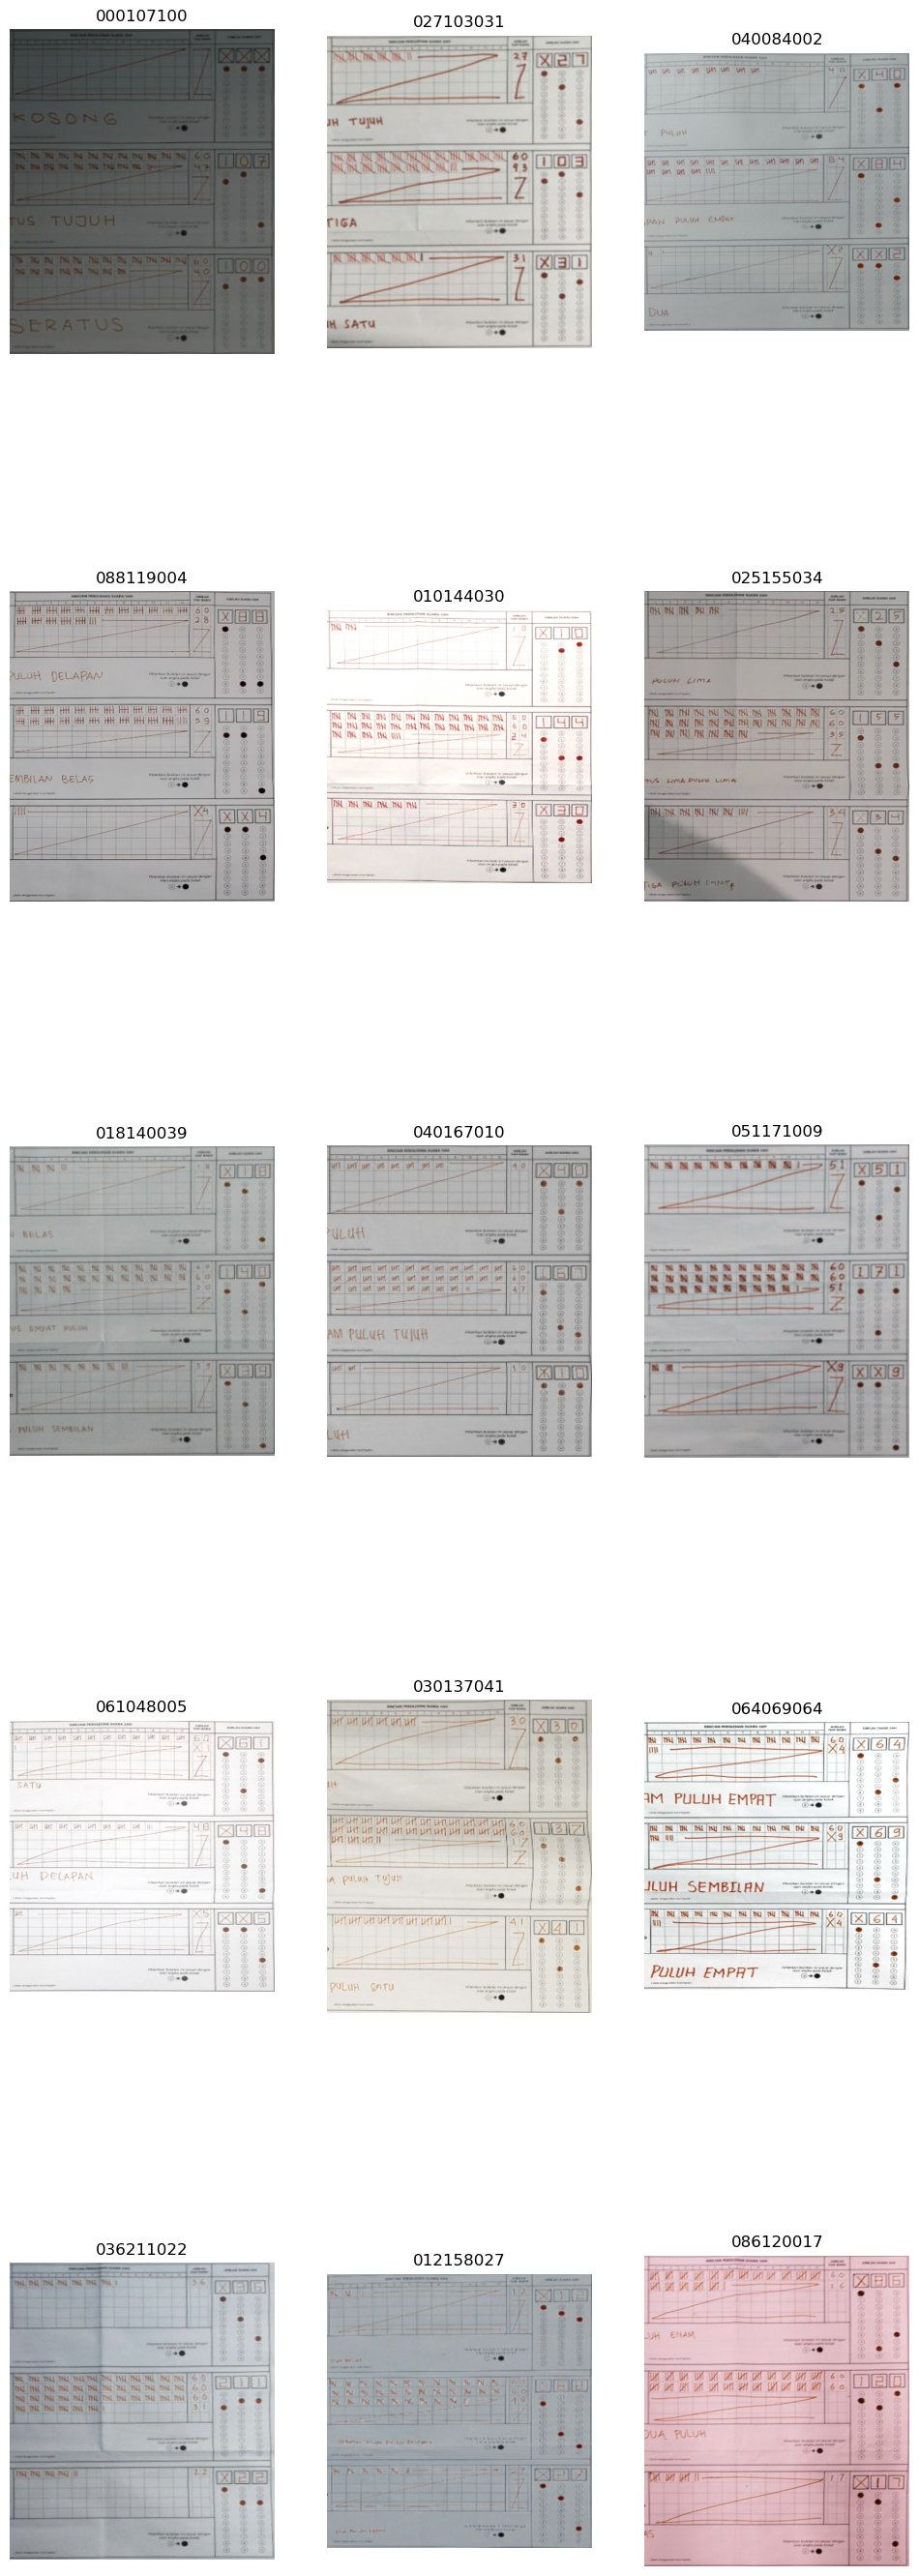

In [212]:
random_int = [np.random.randint(0,len(df_submit)) for _ in range(15)]
fig, axes = plt.subplots(5, 3, figsize=(12, 36))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(f"Datasets/gammafest/Test/{list_submit_image[random_int[i]]}")
    ax.imshow(img)
    ax.set_title(clean_pred[random_int[i]])
    ax.axis('off')

In [213]:
df_submit.to_csv("gatau.csv", index=False)